In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Make sure to upload your Excel file to Colab before proceeding.")

Libraries imported successfully!
Make sure to upload your Excel file to Colab before proceeding.


In [75]:
def load_excel_data(file_path, sheet_name=0):
    """
    Load data from Excel file
    """
    try:
        data = pd.read_excel(file_path, sheet_name=sheet_name)
        print(f"Data loaded successfully!")
        print(f"Shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(data, target_columns=None, handle_missing='drop'):
    """
    Preprocess data for LPA
    """
    if target_columns is not None:
        data = data[target_columns].copy()

    # Handle missing values
    if handle_missing == 'drop':
        data = data.dropna()
    elif handle_missing == 'mean':
        data = data.fillna(data.mean())

    # Select only numeric columns
    numeric_data = data.select_dtypes(include=[np.number])

    print(f"Preprocessed data shape: {numeric_data.shape}")
    print(f"Selected columns: {list(numeric_data.columns)}")

    return numeric_data

def standardize_data(data):
    """
    Standardize data (z-score normalization)
    """
    standardized = (data - data.mean()) / data.std()
    return standardized

# Test functions (you'll use these after uploading your Excel file)
print("Data loading and preprocessing functions defined!")



Data loading and preprocessing functions defined!


In [76]:
# Cell 3: Core Latent Profile Analysis Implementation

class LatentProfileAnalysis:
    def __init__(self, n_profiles=2, max_iter=100, tol=1e-6, random_state=42):
        self.n_profiles = n_profiles
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)

    def initialize_parameters(self, X):
        """Initialize parameters for EM algorithm"""
        n_samples, n_features = X.shape

        # Initialize mixing coefficients (weights)
        self.weights = np.ones(self.n_profiles) / self.n_profiles

        # Initialize means using k-means++ style initialization
        self.means = np.zeros((self.n_profiles, n_features))

        # First mean is random data point
        self.means[0] = X[np.random.randint(n_samples)]

        # Subsequent means chosen to be far from existing ones
        for i in range(1, self.n_profiles):
            distances = np.array([min([np.linalg.norm(x - m)**2 for m in self.means[:i]]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_prob = probabilities.cumsum()
            r = np.random.rand()
            self.means[i] = X[np.searchsorted(cumulative_prob, r)]

        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_profiles)])

    def e_step(self, X):
        """Expectation step"""
        n_samples, n_features = X.shape  # Correctly get n_samples and n_features
        responsibilities = np.zeros((n_samples, self.n_profiles))

        for k in range(self.n_profiles):
            try:
                # Calculate multivariate normal density
                rv = multivariate_normal(self.means[k], self.covariances[k])
                responsibilities[:, k] = self.weights[k] * rv.pdf(X)
            except:
                # Handle singular covariance matrix
                responsibilities[:, k] = self.weights[k] * 1e-10

        # Normalize responsibilities
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities_sum[responsibilities_sum == 0] = 1e-10
        responsibilities /= responsibilities_sum

        return responsibilities

    def m_step(self, X, responsibilities):
        """Maximization step"""
        n_samples, n_features = X.shape

        # Update weights
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / n_samples

        # Update means
        for k in range(self.n_profiles):
            if Nk[k] > 0:
                self.means[k] = (responsibilities[:, k].reshape(-1, 1) * X).sum(axis=0) / Nk[k]

        # Update covariances
        for k in range(self.n_profiles):
            if Nk[k] > 0:
                diff = X - self.means[k]
                weighted_diff = responsibilities[:, k].reshape(-1, 1) * diff
                self.covariances[k] = np.dot(weighted_diff.T, diff) / Nk[k]

                # Add small regularization to prevent singular matrices
                self.covariances[k] += np.eye(n_features) * 1e-6

    def calculate_log_likelihood(self, X):
        """Calculate log-likelihood of the data"""
        n_samples, n_features = X.shape # Correctly get n_samples and n_features
        log_likelihood = 0

        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_profiles):
                try:
                    rv = multivariate_normal(self.means[k], self.covariances[k])
                    sample_likelihood += self.weights[k] * rv.pdf(X[i])
                except:
                    sample_likelihood += self.weights[k] * 1e-10

            log_likelihood += np.log(max(sample_likelihood, 1e-10))

        return log_likelihood

    def fit(self, X):
        """Fit the LPA model"""
        print(f"Fitting LPA model with {self.n_profiles} profiles...")

        self.initialize_parameters(X)
        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self.e_step(X)

            # M-step
            self.m_step(X, responsibilities)

            # Calculate log-likelihood
            log_likelihood = self.calculate_log_likelihood(X)

            # Check convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged after {iteration + 1} iterations")
                break

            prev_log_likelihood = log_likelihood

        # Final predictions
        self.labels_ = self.predict(X)
        self.log_likelihood_ = log_likelihood

        return self

    def predict(self, X):
        """Predict profile membership"""
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)

    def predict_proba(self, X):
        """Predict profile membership probabilities"""
        return self.e_step(X)

print("Latent Profile Analysis class defined!")

Latent Profile Analysis class defined!


In [77]:
# Cell 4: Model Selection and Information Criteria

def calculate_information_criteria(lpa_model, X):
    """Calculate AIC, BIC, and other fit indices"""
    n_samples, n_features = X.shape
    n_profiles = lpa_model.n_profiles

    # Number of parameters
    # For each profile: mean (n_features) + covariance (n_features*(n_features+1)/2) + weight (1, but sum to 1, so n_profiles-1)
    n_params = n_profiles * (n_features + n_features * (n_features + 1) // 2) + (n_profiles - 1)

    log_likelihood = lpa_model.log_likelihood_

    # Information criteria
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(n_samples)

    # Sample-size adjusted BIC
    sabic = -2 * log_likelihood + n_params * np.log((n_samples + 2) / 24)

    return {
        'n_profiles': n_profiles,
        'log_likelihood': log_likelihood,
        'AIC': aic,
        'BIC': bic,
        'SABIC': sabic,
        'n_parameters': n_params
    }

def fit_multiple_profiles(X, max_profiles=6, random_state=42):
    """Fit LPA models with different numbers of profiles"""
    results = []
    models = {}

    print("Fitting models with different numbers of profiles...")

    for n_profiles in range(1, max_profiles + 1):
        print(f"\nFitting model with {n_profiles} profiles...")

        # Fit model
        lpa = LatentProfileAnalysis(n_profiles=n_profiles, random_state=random_state)
        lpa.fit(X)

        # Calculate fit indices
        fit_indices = calculate_information_criteria(lpa, X)
        results.append(fit_indices)
        models[n_profiles] = lpa

        print(f"AIC: {fit_indices['AIC']:.2f}, BIC: {fit_indices['BIC']:.2f}")

    return pd.DataFrame(results), models

print("Model selection functions defined!")

Model selection functions defined!


In [78]:
# Cell 5: Visualization Functions

def plot_fit_indices(fit_results):
    """Plot information criteria for model selection"""
    # Ensure fit_results is a pandas DataFrame for plotting
    if isinstance(fit_results, np.ndarray):
        # Assuming the structure matches the DataFrame output from fit_multiple_profiles
        # If the structure is different, this conversion might need adjustment
        try:
            # Assuming column order: n_profiles, log_likelihood, AIC, BIC, SABIC, n_parameters
            fit_results = pd.DataFrame(fit_results, columns=['n_profiles', 'log_likelihood', 'AIC', 'BIC', 'SABIC', 'n_parameters'])
        except ValueError:
            print("Warning: Could not convert fit_results array to DataFrame for plotting.")
            return # Cannot proceed with plotting if conversion fails

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # AIC plot
    axes[0].plot(fit_results['n_profiles'], fit_results['AIC'], 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Profiles')
    axes[0].set_ylabel('AIC')
    axes[0].set_title('Akaike Information Criterion')
    axes[0].grid(True, alpha=0.3)

    # BIC plot
    axes[1].plot(fit_results['n_profiles'], fit_results['BIC'], 'o-', color='orange', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Profiles')
    axes[1].set_ylabel('BIC')
    axes[1].set_title('Bayesian Information Criterion')
    axes[1].grid(True, alpha=0.3)

    # SABIC plot
    axes[2].plot(fit_results['n_profiles'], fit_results['SABIC'], 'o-', color='green', linewidth=2, markersize=8)
    axes[2].set_xlabel('Number of Profiles')
    axes[2].set_ylabel('SABIC')
    axes[2].set_title('Sample-size Adjusted BIC')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find optimal number of profiles
    best_aic = fit_results.loc[fit_results['AIC'].idxmin(), 'n_profiles']
    best_bic = fit_results.loc[fit_results['BIC'].idxmin(), 'n_profiles']
    best_sabic = fit_results.loc[fit_results['SABIC'].idxmin(), 'n_profiles']

    print(f"\nOptimal number of profiles:")
    print(f"AIC suggests: {best_aic} profiles")
    print(f"BIC suggests: {best_bic} profiles")
    print(f"SABIC suggests: {best_sabic} profiles")

def plot_profile_means(lpa_model, feature_names, standardized=True):
    """Plot profile means"""
    fig, ax = plt.subplots(figsize=(12, 6))

    x_pos = np.arange(len(feature_names))
    width = 0.8 / lpa_model.n_profiles

    for i in range(lpa_model.n_profiles):
        ax.bar(x_pos + i * width, lpa_model.means[i], width,
               label=f'Profile {i+1} (n={np.sum(lpa_model.labels_ == i)})',
               alpha=0.8)

    ax.set_xlabel('Features')
    ax.set_ylabel('Mean Values' + (' (Standardized)' if standardized else ''))
    ax.set_title('Profile Means Comparison')
    ax.set_xticks(x_pos + width * (lpa_model.n_profiles - 1) / 2)
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_profile_distributions(X, lpa_model, feature_names):
    """Plot distributions of each feature by profile"""
    n_features = X.shape[1] # Corrected to get the number of features
    n_profiles = lpa_model.n_profiles

    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))
    if n_features == 1:
        axes = [axes] # Ensure axes is iterable even for 1 feature

    for i, feature in enumerate(feature_names):
        for profile in range(n_profiles):
            profile_data = X[lpa_model.labels_ == profile, i]
            axes[i].hist(profile_data, alpha=0.6, label=f'Profile {profile+1}', bins=20)

        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Distribution of {feature} by Profile')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Visualization functions defined!")

Visualization functions defined!


In [79]:
# Cell 6: Profile Interpretation and Analysis Functions

def analyze_profiles(X, lpa_model, feature_names):
    """Comprehensive profile analysis"""
    results = {}

    print("="*60)
    print("LATENT PROFILE ANALYSIS RESULTS")
    print("="*60)

    # Overall model information
    print(f"\nModel Information:")
    print(f"Number of profiles: {lpa_model.n_profiles}")
    print(f"Number of observations: {X.shape}")
    print(f"Number of features: {X.shape}")
    print(f"Log-likelihood: {lpa_model.log_likelihood_:.2f}")

    # Profile sizes and proportions
    print(f"\nProfile Sizes:")
    profile_counts = np.bincount(lpa_model.labels_)
    for i in range(lpa_model.n_profiles):
        proportion = profile_counts[i] / len(lpa_model.labels_) * 100
        print(f"Profile {i+1}: {profile_counts[i]} observations ({proportion:.1f}%)")

    # Profile means and standard deviations
    print(f"\nProfile Characteristics:")
    profile_stats = []

    for i in range(lpa_model.n_profiles):
        profile_mask = lpa_model.labels_ == i
        profile_data = X[profile_mask]

        print(f"\nProfile {i+1}:")
        print("-" * 20)

        profile_means = profile_data.mean(axis=0)
        profile_stds = profile_data.std(axis=0)

        for j, feature in enumerate(feature_names):
            print(f"{feature}: Mean = {profile_means[j]:.3f}, SD = {profile_stds[j]:.3f}")

        profile_stats.append({
            'profile': i+1,
            'size': profile_counts[i],
            'proportion': proportion,
            'means': profile_means,
            'stds': profile_stds
        })

    results['profile_stats'] = profile_stats
    results['profile_counts'] = profile_counts

    return results

def create_profile_summary_table(analysis_results, feature_names):
    """Create a summary table of profile characteristics"""
    profile_stats = analysis_results['profile_stats']

    # Create summary dataframe
    summary_data = []
    for stats in profile_stats:
        row = {'Profile': stats['profile'], 'Size': stats['size'], 'Proportion': f"{stats['proportion']:.1f}%"}
        for i, feature in enumerate(feature_names):
            row[f"{feature}_mean"] = f"{stats['means'][i]:.3f}"
            row[f"{feature}_std"] = f"{stats['stds'][i]:.3f}"
        summary_data.append(row)

    summary_df = pd.DataFrame(summary_data)

    print("\nProfile Summary Table:")
    print("="*80)
    display(summary_df)

    return summary_df

def calculate_profile_separation(lpa_model, X):
    """Calculate how well-separated the profiles are"""
    # Calculate silhouette-like measure
    from scipy.spatial.distance import cdist

    profile_centers = lpa_model.means
    separations = []

    for i in range(lpa_model.n_profiles):
        for j in range(i+1, lpa_model.n_profiles):
            distance = np.linalg.norm(profile_centers[i] - profile_centers[j])
            separations.append(distance)

    avg_separation = np.mean(separations)
    min_separation = np.min(separations)

    print(f"\nProfile Separation Analysis:")
    print(f"Average distance between profile centers: {avg_separation:.3f}")
    print(f"Minimum distance between profile centers: {min_separation:.3f}")

    return avg_separation, min_separation

print("Profile analysis functions defined!")

Profile analysis functions defined!


In [80]:
# Cell 7: Main Execution Script

def run_complete_lpa_analysis(file_path, sheet_name=0, target_columns=None,
                             max_profiles=6, standardize_flag=True):
    """
    Run complete LPA analysis

    Parameters:
    - file_path: path to Excel file
    - sheet_name: Excel sheet name or index
    - target_columns: list of column names to analyze (None for all numeric)
    - max_profiles: maximum number of profiles to test
    - standardize_flag: whether to standardize the data
    """

    print("Starting Comprehensive Latent Profile Analysis...")
    print("="*60)

    # Step 1: Load and preprocess data
    print("\n1. Loading and preprocessing data...")
    raw_data = load_excel_data(file_path, sheet_name)
    if raw_data is None:
        return None

    # Display basic info about the data
    print("\nData Overview:")
    print(raw_data.head())
    print(f"\nData Info:")
    print(raw_data.info())

    # Preprocess data
    processed_data = preprocess_data(raw_data, target_columns)
    if processed_data.empty:
        print("No numeric data found!")
        return None

    # Standardize if requested
    if standardize_flag:
        print("\nStandardizing data...")
        analysis_data = standardize_data(processed_data)
        feature_names = list(processed_data.columns)
    else:
        analysis_data = processed_data.values
        feature_names = list(processed_data.columns)

    X = analysis_data.values if hasattr(analysis_data, 'values') else analysis_data


    # Step 2: Model selection
    print(f"\n2. Testing models with 1-{max_profiles} profiles...")
    fit_results, models = fit_multiple_profiles(X, max_profiles)

    # Display fit results
    print("\nModel Fit Results:")
    display(fit_results)

    # Plot fit indices
    plot_fit_indices(fit_results)

    # Step 3: Select best model (using BIC as default)
    best_n_profiles = fit_results.loc[fit_results['BIC'].idxmin(), 'n_profiles']
    best_model = models[best_n_profiles]

    print(f"\n3. Selected model with {best_n_profiles} profiles (lowest BIC)")

    # Step 4: Detailed analysis of best model
    print("\n4. Analyzing selected model...")
    analysis_results = analyze_profiles(X, best_model, feature_names)

    # Create summary table
    summary_table = create_profile_summary_table(analysis_results, feature_names)

    # Calculate profile separation
    calculate_profile_separation(best_model, X)

    # Step 5: Visualizations
    print("\n5. Creating visualizations...")

    # Plot profile means
    plot_profile_means(best_model, feature_names, standardized=standardize_flag)

    # Plot distributions
    plot_profile_distributions(X, best_model, feature_names)

    # Additional correlation heatmap if multiple features
    if len(feature_names) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = np.corrcoef(X.T)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   xticklabels=feature_names, yticklabels=feature_names)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

    # Step 6: Export results
    print("\n6. Preparing results for export...")

    # Add profile assignments to original data
    results_data = processed_data.copy()
    results_data['Profile'] = best_model.labels_ + 1  # Start from 1 instead of 0
    results_data['Profile_Probability'] = np.max(best_model.predict_proba(X), axis=1)

    # Display sample of results
    print("\nSample of results with profile assignments:")
    display(results_data.head(10))

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

    return {
        'original_data': raw_data,
        'processed_data': processed_data,
        'analysis_data': X,
        'feature_names': feature_names,
        'fit_results': fit_results,
        'models': models,
        'best_model': best_model,
        'best_n_profiles': best_n_profiles,
        'analysis_results': analysis_results,
        'summary_table': summary_table,
        'results_data': results_data
    }

print("Main execution function defined!")
print("\nReady to run analysis! Use the next cell to execute.")

Main execution function defined!

Ready to run analysis! Use the next cell to execute.


Starting Comprehensive Latent Profile Analysis...

1. Loading and preprocessing data...
Data loaded successfully!
Shape: (459, 10)
Columns: ['PER', 'MW', 'STR', 'WE', 'MWSqu', 'STRSqu', 'WESqu', 'MW_STR', 'MW_WE', 'STR_WE']

Data Overview:
        PER   MW  STR        WE  MWSqu  STRSqu      WESqu  MW_STR      MW_WE  \
0  6.000000  4.0  4.0  5.666667  16.00    16.0  32.111111    16.0  22.666667   
1  5.000000  3.0  3.0  4.444444   9.00     9.0  19.753086     9.0  13.333333   
2  5.000000  3.5  4.0  3.888889  12.25    16.0  15.123457    14.0  13.611111   
3  7.000000  5.0  5.0  6.888889  25.00    25.0  47.456790    25.0  34.444444   
4  4.857143  4.0  4.0  4.444444  16.00    16.0  19.753086    16.0  17.777778   

      STR_WE  
0  22.666667  
1  13.333333  
2  15.555556  
3  34.444444  
4  17.777778  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  ----- 

,n_profiles,log_likelihood,AIC,BIC,SABIC,n_parameters
0,1,1183.504150,-2237.008300,-1968.620036,-2174.910926,65
1,2,2765.290203,-5268.580407,-4727.674829,-5143.430315,131
2,3,3803.654808,-7213.309616,-6399.886725,-7025.106806,197
3,4,3998.250337,-7470.500674,-6384.560469,-7219.245146,263
4,5,4352.896411,-8047.792823,-6689.335303,-7733.484577,329
5,6,5068.285687,-9346.571374,-7715.596541,-8969.210410,395


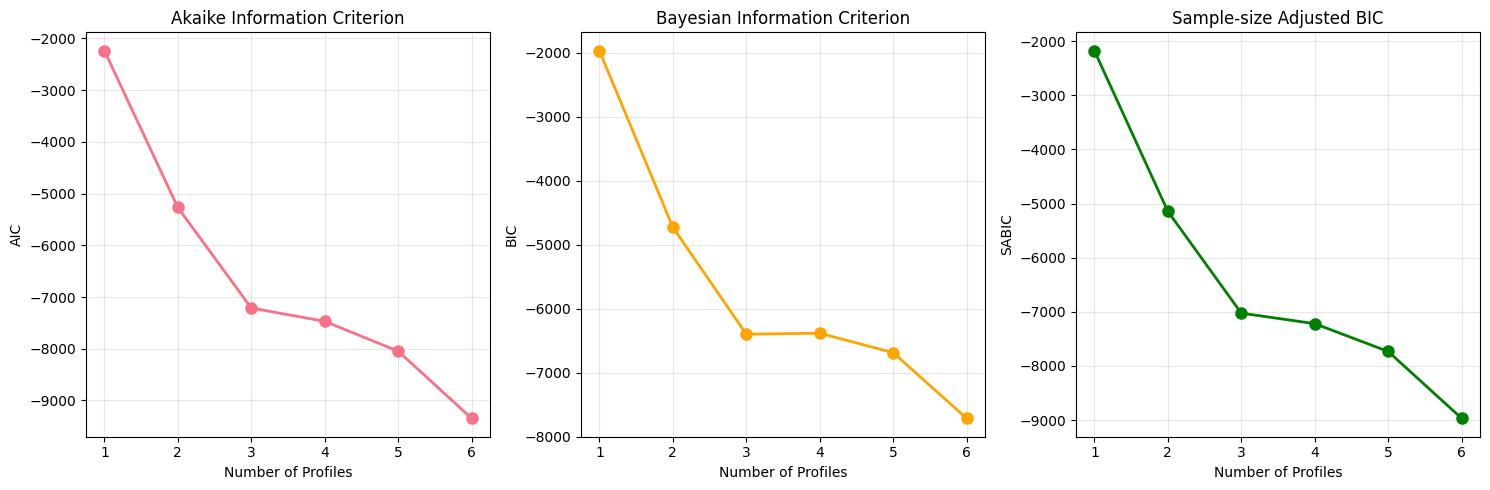


Optimal number of profiles:
AIC suggests: 6 profiles
BIC suggests: 6 profiles
SABIC suggests: 6 profiles

3. Selected model with 6 profiles (lowest BIC)

4. Analyzing selected model...
LATENT PROFILE ANALYSIS RESULTS

Model Information:
Number of profiles: 6
Number of observations: (459, 10)
Number of features: (459, 10)
Log-likelihood: 5068.29

Profile Sizes:
Profile 1: 63 observations (13.7%)
Profile 2: 152 observations (33.1%)
Profile 3: 109 observations (23.7%)
Profile 4: 14 observations (3.1%)
Profile 5: 50 observations (10.9%)
Profile 6: 71 observations (15.5%)

Profile Characteristics:

Profile 1:
--------------------
PER: Mean = -0.550, SD = 1.169
MW: Mean = -1.305, SD = 0.725
STR: Mean = -1.134, SD = 0.617
WE: Mean = -0.646, SD = 0.460
MWSqu: Mean = -1.274, SD = 0.612
STRSqu: Mean = -1.126, SD = 0.531
WESqu: Mean = -0.686, SD = 0.410
MW_STR: Mean = -1.344, SD = 0.422
MW_WE: Mean = -1.027, SD = 0.468
STR_WE: Mean = -0.956, SD = 0.363

Profile 2:
--------------------
PER: Mean 

,Profile,Size,Proportion,PER_mean,PER_std,MW_mean,MW_std,STR_mean,STR_std,WE_mean,...,STRSqu_mean,STRSqu_std,WESqu_mean,WESqu_std,MW_STR_mean,MW_STR_std,MW_WE_mean,MW_WE_std,STR_WE_mean,STR_WE_std
0,1,63,15.5%,-0.550,1.169,-1.305,0.725,-1.134,0.617,-0.646,...,-1.126,0.531,-0.686,0.410,-1.344,0.422,-1.027,0.468,-0.956,0.363
1,2,152,15.5%,0.476,0.862,0.599,0.677,1.096,0.176,0.708,...,1.156,0.210,0.715,0.840,0.975,0.507,0.748,0.796,1.003,0.578
2,3,109,15.5%,-0.127,0.845,-0.071,0.358,-0.286,0.347,-0.220,...,-0.358,0.353,-0.289,0.516,-0.255,0.283,-0.239,0.312,-0.332,0.386
3,4,14,15.5%,-0.708,1.355,-1.778,1.604,-2.472,0.548,-2.021,...,-2.148,0.332,-1.703,0.272,-2.099,0.677,-1.840,0.575,-2.073,0.290
4,5,50,15.5%,-0.477,0.915,-0.538,0.682,-0.570,0.731,-1.375,...,-0.603,0.726,-1.273,0.310,-0.656,0.610,-1.095,0.419,-1.141,0.415
5,6,71,15.5%,0.138,0.737,0.713,0.589,-0.012,0.395,0.762,...,-0.078,0.409,0.753,0.613,0.372,0.469,0.812,0.411,0.423,0.418



Profile Separation Analysis:
Average distance between profile centers: 4.164
Minimum distance between profile centers: 1.743

5. Creating visualizations...


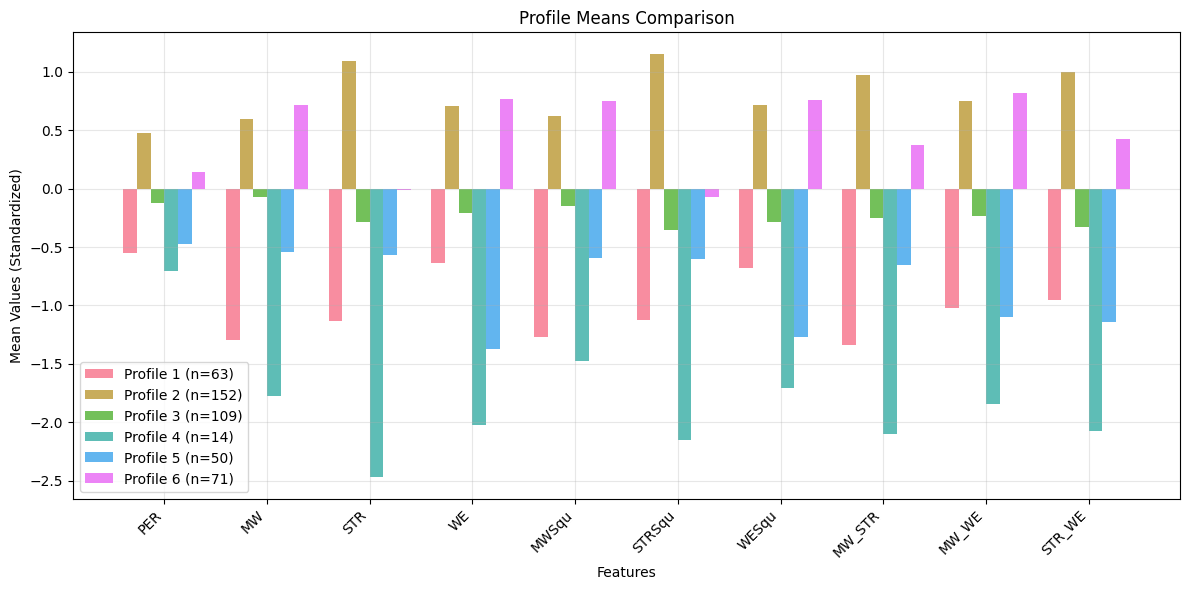

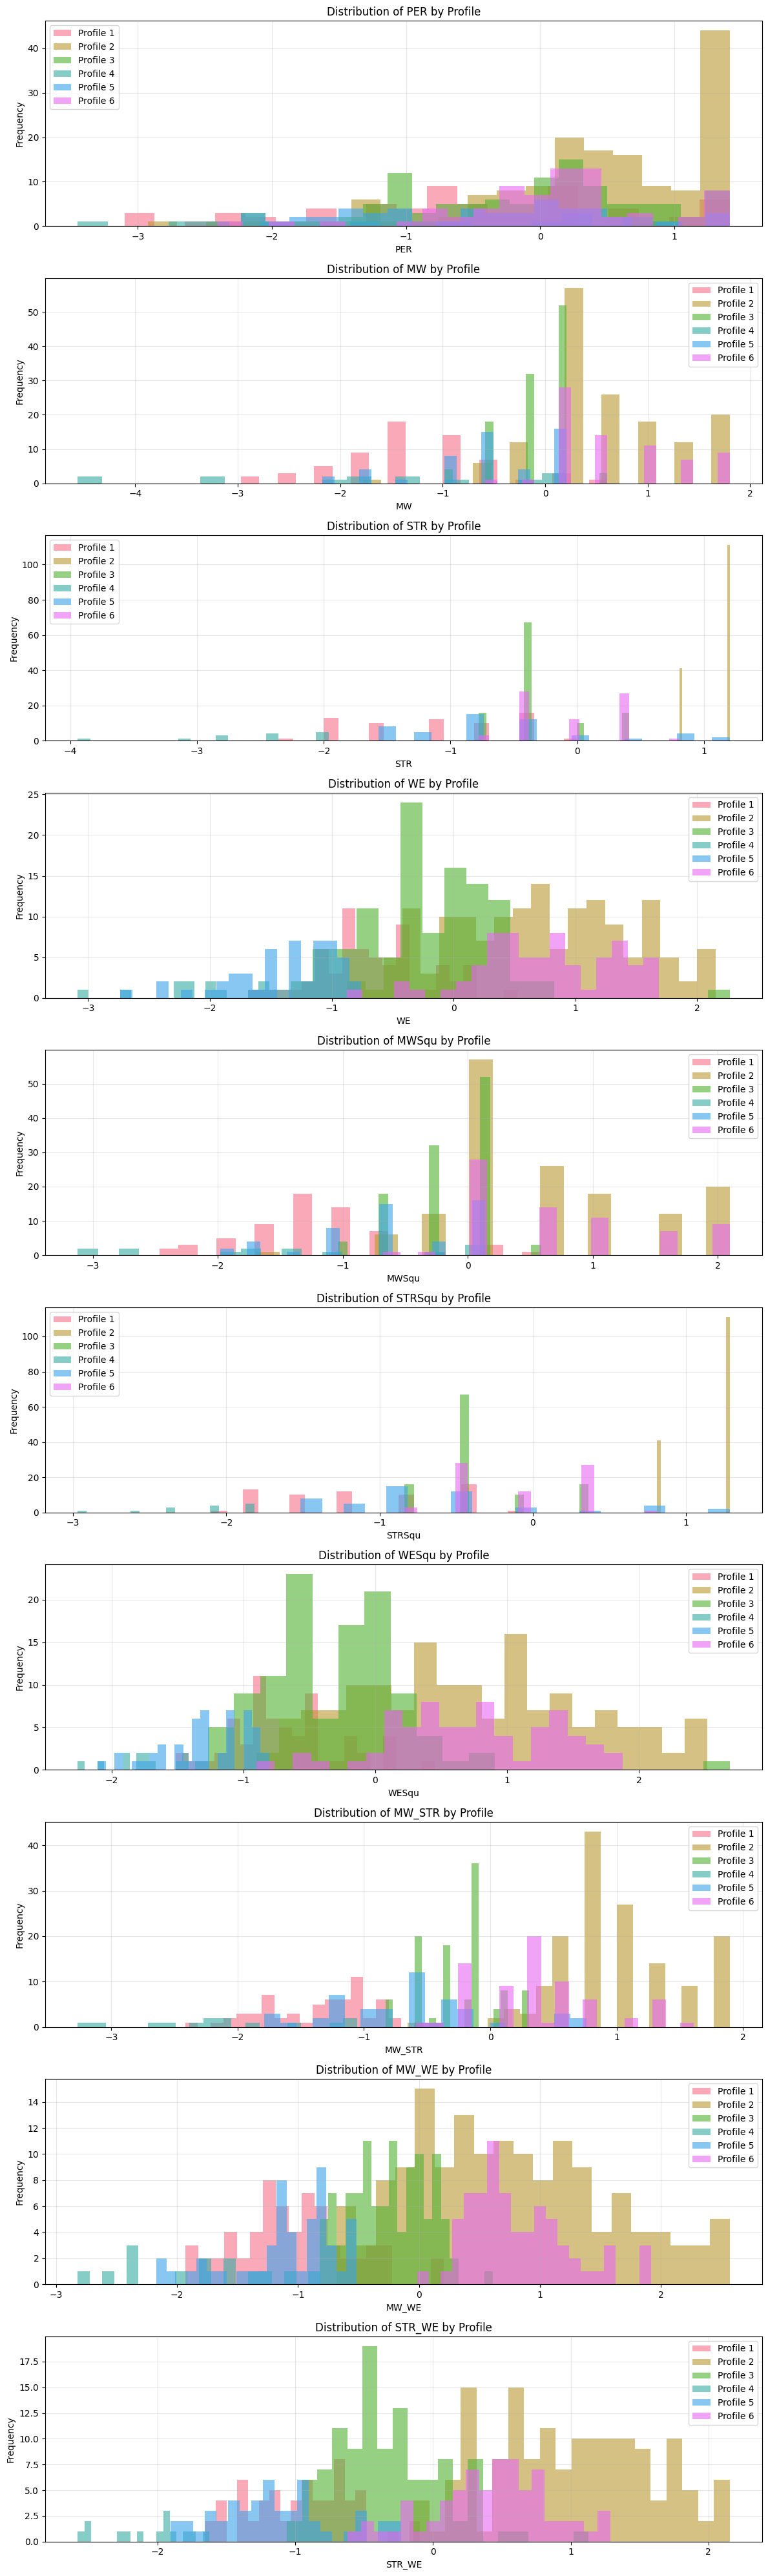

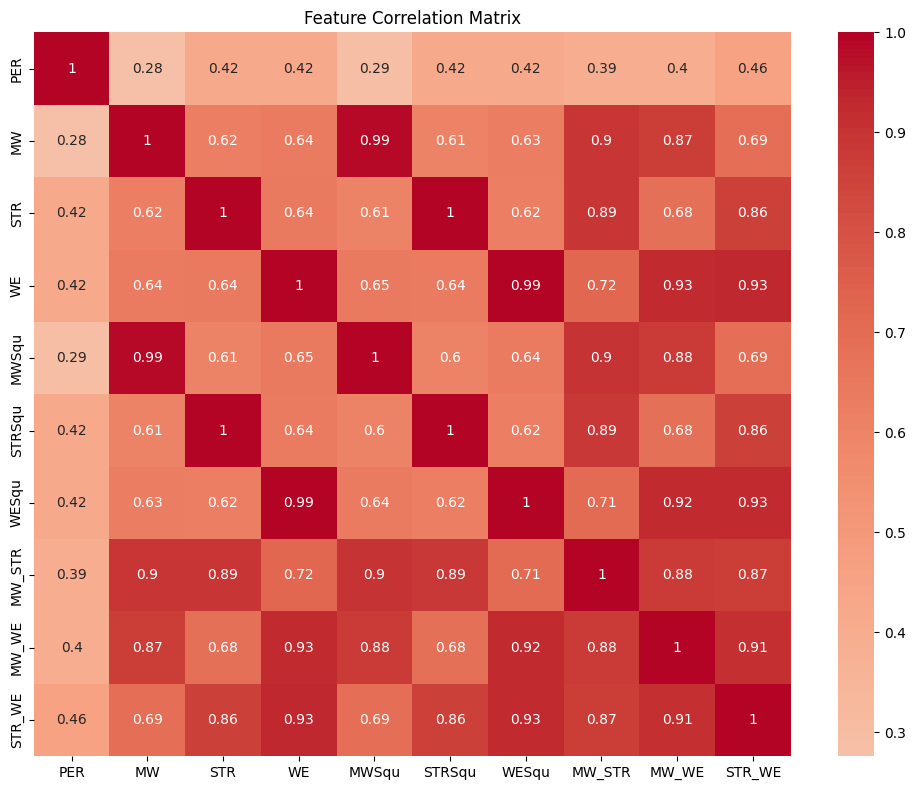


6. Preparing results for export...

Sample of results with profile assignments:


,PER,MW,STR,WE,MWSqu,STRSqu,WESqu,MW_STR,MW_WE,STR_WE,Profile,Profile_Probability
0,6.000000,4.00,4.0,5.666667,16.0000,16.00,32.111111,16.00,22.666667,22.666667,6,1.000000
1,5.000000,3.00,3.0,4.444444,9.0000,9.00,19.753086,9.00,13.333333,13.333333,1,1.000000
2,5.000000,3.50,4.0,3.888889,12.2500,16.00,15.123457,14.00,13.611111,15.555556,5,0.998269
3,7.000000,5.00,5.0,6.888889,25.0000,25.00,47.456790,25.00,34.444444,34.444444,2,1.000000
4,4.857143,4.00,4.0,4.444444,16.0000,16.00,19.753086,16.00,17.777778,17.777778,3,1.000000
5,5.857143,4.50,4.5,6.000000,20.2500,20.25,36.000000,20.25,27.000000,27.000000,6,1.000000
6,7.000000,4.00,5.0,5.555556,16.0000,25.00,30.864198,20.00,22.222222,27.777778,2,1.000000
7,6.000000,4.25,5.0,6.333333,18.0625,25.00,40.111111,21.25,26.916667,31.666667,2,1.000000
8,4.714286,4.00,3.5,3.777778,16.0000,12.25,14.271605,14.00,15.111111,13.222222,5,1.000000
9,6.285714,3.50,4.0,3.333333,12.2500,16.00,11.111111,14.00,11.666667,13.333333,5,1.000000



ANALYSIS COMPLETE!
Modify the file_path variable above and uncomment the last line to run the analysis!

Example:
results = run_complete_lpa_analysis("my_data.xlsx", 0, None, 6, True)


In [81]:
# Cell 8: Execute Analysis (MODIFY THIS CELL WITH YOUR FILE PATH)

# IMPORTANT: Upload your Excel file to Google Colab first!
# Then modify the file_path below to match your uploaded file

# Example usage:
file_path = "data.xlsx"  # Change this to your actual file path
sheet_name = 0  # Change if you want a different sheet
target_columns = None  # Specify column names as list, or None for all numeric columns
max_profiles = 6  # Maximum number of profiles to test
standardize_flag = True  # Whether to standardize the data

# Uncomment the line below and modify the file_path to run the analysis:
results = run_complete_lpa_analysis(file_path, sheet_name, target_columns, max_profiles, standardize_flag)

print("Modify the file_path variable above and uncomment the last line to run the analysis!")
print("\nExample:")
print('results = run_complete_lpa_analysis("my_data.xlsx", 0, None, 6, True)')